In [15]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import import_ipynb
import gzip
from anndata import AnnData
import requests
import seaborn as sns


In [3]:
def download_binary_file(file_url: str, output_path: str) -> None:
    """
    Download binary data file from a URL.

    Args:
    ----
        file_url: URL where the file is hosted.
        output_path: Output path for the downloaded file.

    Returns
    -------
        None.
    """
    request = requests.get(file_url)
    with open(output_path, "wb") as f:
        f.write(request.content)
    print(f"Downloaded data from {file_url} at {output_path}")

    

def download_haber_2017(output_path: str) -> None:
    """
    Download Haber et al. 2017 data from the hosting URLs.

    Args:
    ----
        output_path: Output path to store the downloaded and unzipped
        directories.

    Returns
    -------
        None. File directories are downloaded to output_path.
    """

    url = (
        "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92332/suppl/GSE92332"
        "_SalmHelm_UMIcounts.txt.gz"
    )

    output_filename = os.path.join(output_path, url.split("/")[-1])

    download_binary_file(url, output_filename)
def read_haber_2017(file_directory: str) -> pd.DataFrame:
    """
    Read the expression data from Haber et al. 2017 given the directory.

    Args:
    ----
        file_directory: Directory containing Haber et al. 2017 data.

    Returns
    -------
        A DataFrame containing single-cell gene expression counts, with cell
        identification barcodes as column names and gene IDs as indices.
    """

    # Path to the file
    file_path = os.path.join(file_directory, "GSE92332_SalmHelm_UMIcounts.txt.gz")
    
    # Read the .txt.gz file, assuming the first column contains gene names
    with gzip.open(file_path, "rt") as f:
        df = pd.read_csv(f, sep="\t", index_col=0)

    return df

def preprocess_haber_2017(download_path: str, n_top_genes: int) -> (AnnData, list):
    """
    Preprocess expression data from Haber et al. 2017.

    Args:
    ----
        download_path: Path containing the downloaded Haber et al. 2017 data file.
        n_top_genes: Number of most variable genes to retain.

    Returns
    -------
        An AnnData object containing single-cell expression data. The layer
        "count" contains the count data for the most variable genes. The X
        variable contains the total-count-normalized and log-transformed data
        for the most variable genes (a copy with all the genes is stored in
        .raw).
        A list of conditions associated with each cell.
    """

    # Read the expression data
    df = read_haber_2017(download_path)
    
    # Transpose the dataframe so that genes become columns and cells are rows
    df = df.transpose()

    # Extract metadata from the cell names
    cell_groups = []
    barcodes = []
    conditions = []
    cell_types = []
    cell_names = []

    for cell in df.index:
        try:
            cell_group, barcode, condition, cell_type = cell.split("_")
            cell_groups.append(cell_group)
            barcodes.append(barcode)
            conditions.append(condition)
            cell_types.append(cell_type)
            cell_names.append(cell)
        except ValueError:
            print(f"Error parsing cell name: {cell}")
            continue

    # Create a DataFrame for metadata
    metadata_df = pd.DataFrame(
        {
            "cell_group": cell_groups,
            "barcode": barcodes,
            "condition": conditions,
            "cell_type": cell_types,
        }, index=cell_names  # Ensure the cell names are set as the index
    )

    # Create the AnnData object with gene names in 'var' and cell metadata in 'obs'
    adata = AnnData(X=df.values, obs=metadata_df, var=pd.DataFrame(index=df.columns))

    # Preprocess the data: normalize, log-transform, and keep most variable genes
    adata = adata[adata.obs["condition"] != "Hpoly.Day3"]
    adata.layers["count"] = adata.X.copy()

    # Normalize and log-transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.raw = adata

    # Select highly variable genes
    sc.pp.highly_variable_genes(
        adata, flavor="seurat_v3", n_top_genes=n_top_genes, layer="count", subset=True
    )

    # Remove cells with all zero counts
    adata = adata[adata.layers["count"].sum(1) != 0]  # Remove cells with all zeros.

    # Return the AnnData object and the conditions list
    return adata, conditions


In [4]:
root_data_path = ""   # local computer data path to downloaad the dataset. 

download_haber_2017(root_data_path)

Downloaded data from https://ftp.ncbi.nlm.nih.gov/geo/series/GSE92nnn/GSE92332/suppl/GSE92332_SalmHelm_UMIcounts.txt.gz at GSE92332_SalmHelm_UMIcounts.txt.gz


In [5]:
data, conditions = preprocess_haber_2017(root_data_path, 1000)

C:\Users\Eric\AppData\Local\Temp\ipykernel_6904\3442865371.py:125: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata.layers["count"] = adata.X.copy()


In [6]:
foreground = data[data.obs["condition"] != "Control"]
k, p = foreground.shape

background = data[data.obs["condition"] == "Control"]
m, p = background.shape

foreground = foreground.to_df()
background = background.to_df()

labels = np.where(foreground.index.str.contains('Salmonella'), 0, 1)

In [7]:
genes = foreground.columns.to_numpy()
foreground_cells = foreground.index.to_numpy()
X = foreground.to_numpy()
Y = background.to_numpy()

In [8]:
os.chdir('C:/Users/Eric/OneDrive - University of North Carolina at Chapel Hill/dissertation work/project 2 - contrastive cur')
from main import*

In [53]:
c = 10
k = 5
cols_contrastive = ccur(X, Y, k, c)[0]
genes[cols_contrastive]

array(['Retnlb', 'Lrg1', 'B3galt5', 'Prss53', 'St6galnac6', 'Cwh43',
       'Fut2', 'Saa1', 'Inpp5d', 'Iigp1'], dtype=object)

In [54]:
cols_foreground = deterministic_cur(X, k, c)[3]
genes[cols_foreground]

array(['Reg3g', 'Tff3', 'Lypd8', 'Spink4', 'Krt19', 'Apoa1', 'Dmbt1',
       'Agr2', 'Defa24', 'Fabp1'], dtype=object)

In [55]:
union_indicies = deterministic_cur(np.concatenate((X,Y)), k, c)[3]
genes[union_indicies]

array(['Reg3g', 'Tff3', 'Krt19', 'Spink4', 'Lypd8', 'Apoa1', 'Agr2',
       'Fabp1', 'Guca2a', 'Krt18'], dtype=object)

In [56]:
alpha = 1
constrastive_cov = np.cov(X, rowvar = False) - alpha * np.cov(Y, rowvar = False)
eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)

first_pc = eigenvectors[:, np.argmax(eigenvalues)]  
top_indices = np.argsort(np.abs(first_pc))[-c:] 
genes[top_indices]

array(['Clec2h', 'Anpep', 'Guca2b', 'Defa24', 'Fabp2', 'Reg3g', 'Apoa4',
       'Fabp1', 'Rbp2', 'Apoa1'], dtype=object)

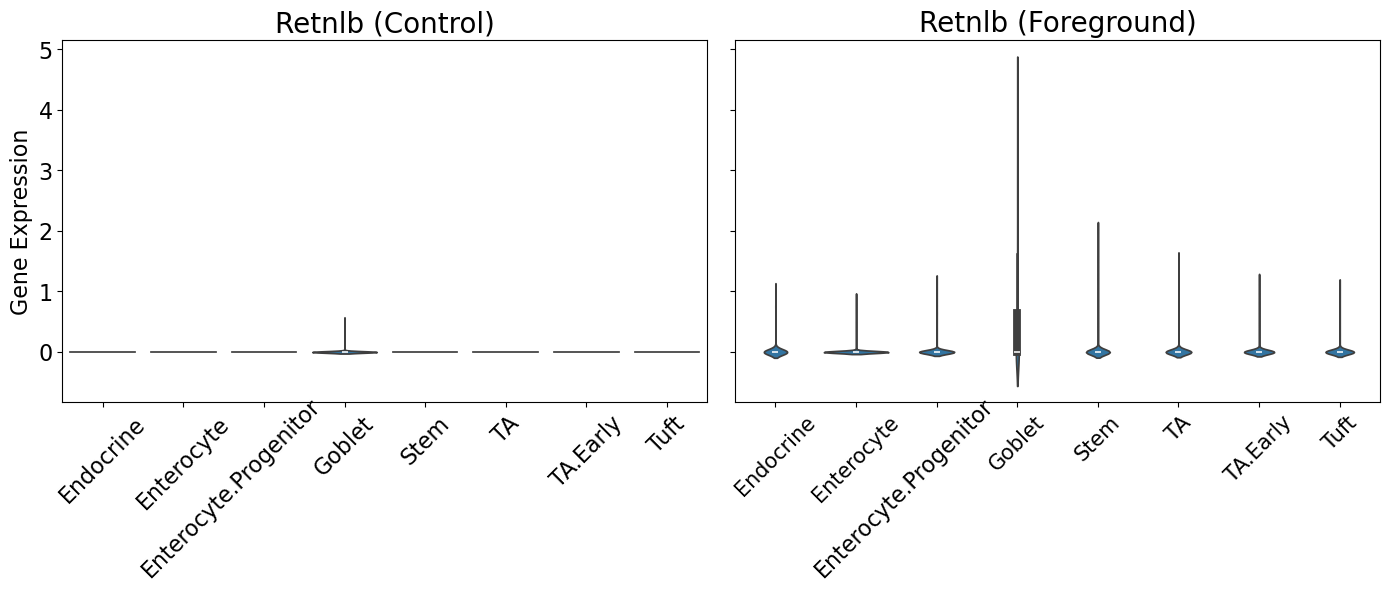

In [57]:
#gene_index = foreground.columns.get_loc("Ang")
gene_index = cols_contrastive[0]  
#gene_index = cols_foreground[4]  
#gene_index = top_indices[5] 

foreground_gene_data = foreground.iloc[:, gene_index]
background_gene_data = background.iloc[:, gene_index]

def extract_cell_type(row_name):
    return row_name.split('_')[-1]  # Get the cell type after the last underscore

foreground_cell_types = pd.Series(foreground.index.map(extract_cell_type), index=foreground.index)
background_cell_types = pd.Series(background.index.map(extract_cell_type), index=background.index)

all_cell_types = sorted(pd.concat([foreground_cell_types, background_cell_types]).unique())

labels = pd.Series(labels, index=foreground.index)  

foreground_gene_data_combined = foreground_gene_data  
foreground_cell_types_combined = foreground_cell_types 

data_control = pd.DataFrame({
    'Gene Expression': background_gene_data,
    'Cell Type': background_cell_types,
    'Group': ['Control'] * len(background_gene_data)  
})

data_foreground_combined = pd.DataFrame({
    'Gene Expression': foreground_gene_data_combined,
    'Cell Type': foreground_cell_types_combined,
    'Group': ['Combined (H.Poly + Salmonella)'] * len(foreground_gene_data_combined)
})

data_combined = pd.concat([data_control, data_foreground_combined])

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.violinplot(x='Cell Type', y='Gene Expression', data=data_control, order=all_cell_types, ax=axes[0])
axes[0].set_title(f"{foreground.columns[gene_index]} (Control)", fontsize=20)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='x', labelsize=16)
axes[0].set_ylabel('Gene Expression', fontsize=16)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].set_xlabel('') 

sns.violinplot(x='Cell Type', y='Gene Expression', data=data_foreground_combined, order=all_cell_types, ax=axes[1])
axes[1].set_title(f"{foreground.columns[gene_index]} (Foreground)", fontsize=20)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_xlabel('') 

tick_labels = axes[0].get_xticks()
tick_labels_text = axes[0].get_xticklabels()
axes[0].text(tick_labels[2] - 0.4, -0.7, tick_labels_text[2].get_text(), 
             fontsize=16, ha='center', va='top', rotation=45)
tick_labels_text[2].set_visible(False)

tick_labels = axes[1].get_xticks()
tick_labels_text = axes[1].get_xticklabels()
axes[1].text(tick_labels[2] - 0.4, -0.7, tick_labels_text[2].get_text(), 
             fontsize=16, ha='center', va='top', rotation=45)

tick_labels_text[2].set_visible(False)

plt.tight_layout()
plt.show()



In [58]:
r =100
rows_contrastive = deterministic_cur(X[:,cols_contrastive],k,r)[4]
rows_foreground = deterministic_cur(X,k, r)[4]


In [59]:
def calculate_proportion(rows, labels):
    """
    Calculate the proportion of 0 and 1 in the selected rows based on the labels array.
    """
    selected_labels = labels[rows]
    total = len(selected_labels)
    count_0 = np.sum(selected_labels == 0)
    count_1 = np.sum(selected_labels == 1)
    proportion_0 = count_0 / total
    proportion_1 = count_1 / total
    return count_0, count_1, proportion_0, proportion_1

count_0_contrastive, count_1_contrastive, prop_0_contrastive, prop_1_contrastive = calculate_proportion(rows_contrastive, labels)
count_0_foreground, count_1_foreground, prop_0_foreground, prop_1_foreground = calculate_proportion(rows_foreground, labels)

total_0 = np.sum(labels == 0)
total_1 = np.sum(labels == 1)
total = len(labels)
total_prop_0 = total_0 / total
total_prop_1 = total_1 / total

print("Proportion in rows_contrastive:")
print(f"Count 0: {count_0_contrastive}, Count 1: {count_1_contrastive}, Proportion 0: {prop_0_contrastive:.2f}, Proportion 1: {prop_1_contrastive:.2f}")

print("\nProportion in rows_foreground:")
print(f"Count 0: {count_0_foreground}, Count 1: {count_1_foreground}, Proportion 0: {prop_0_foreground:.2f}, Proportion 1: {prop_1_foreground:.2f}")

print("\nTotal counts and proportions across all labels:")
print(f"Total Count 0: {total_0}, Total Count 1: {total_1}, Total Proportion 0: {total_prop_0:.2f}, Total Proportion 1: {total_prop_1:.2f}")


Proportion in rows_contrastive:
Count 0: 20, Count 1: 80, Proportion 0: 0.20, Proportion 1: 0.80

Proportion in rows_foreground:
Count 0: 7, Count 1: 93, Proportion 0: 0.07, Proportion 1: 0.93

Total counts and proportions across all labels:
Total Count 0: 1770, Total Count 1: 2711, Total Proportion 0: 0.40, Total Proportion 1: 0.60


C:\Users\Eric\anaconda3\Lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

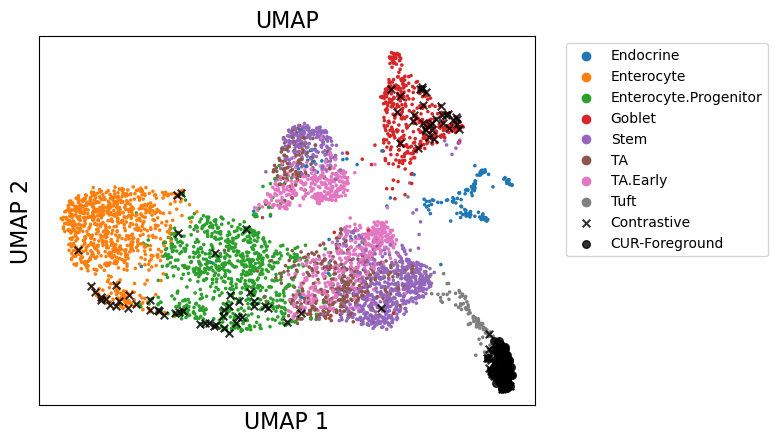

In [60]:
plt.figure(figsize=(10, 8)) 

adata = sc.AnnData(foreground.values)
adata.obs['barcode'] = foreground.index  
adata.var['gene_name'] = foreground.columns  

adata.obs['cell_type'] = adata.obs['barcode'].apply(lambda x: x.split('_')[-1])

sc.pp.neighbors(adata, n_neighbors=30)  # You can adjust the number of neighbors as needed
sc.tl.umap(adata)

sc.pl.umap(adata, color='cell_type', show=False)  # Do not show immediately

contrastive_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[rows_contrastive])].tolist()
foreground_indices = adata.obs.index[adata.obs['barcode'].isin(foreground_cells[rows_foreground])].tolist()

contrastive_indices = [int(i) for i in contrastive_indices]
foreground_indices = [int(i) for i in foreground_indices]

coords = adata.obsm['X_umap']

plt.scatter(coords[contrastive_indices, 0], coords[contrastive_indices, 1], 
            color='black', marker='x', s=30, label='Contrastive', alpha=0.8)
plt.scatter(coords[foreground_indices, 0], coords[foreground_indices, 1], 
            color='black', marker='o', s=30, label='CUR-Foreground', alpha=0.8)

plt.title("UMAP", fontsize=16)
plt.xlabel("UMAP 1", fontsize=16)  
plt.ylabel("UMAP 2", fontsize=16)  

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.show()


In [61]:
adata.obs['int_index'] = adata.obs.index.astype(int)

index_to_cell_type = adata.obs.set_index('int_index')['cell_type']

results = {}

methods = {
    'Contrastive': contrastive_indices,
    'Foreground': foreground_indices,
}

for method_name, indices in methods.items():
    indices = [int(i) for i in indices]
    
    selected_cell_types = index_to_cell_type.loc[indices]
    counts = selected_cell_types.value_counts()
    
    proportions = counts / counts.sum()
    
    results[method_name] = proportions

total_cell_counts = adata.obs['cell_type'].value_counts()
total_proportions = total_cell_counts / total_cell_counts.sum()

results_df = pd.DataFrame(results).fillna(0)

results_df['True_Proportion'] = total_proportions


print(results_df)


                       Contrastive  Foreground  True_Proportion
Endocrine                     0.00         0.0         0.033698
Enterocyte                    0.18         0.0         0.185896
Enterocyte.Progenitor         0.28         0.0         0.181879
Goblet                        0.32         0.0         0.098862
Stem                          0.00         0.0         0.178308
TA                            0.01         0.0         0.103771
TA.Early                      0.02         0.0         0.164249
Tuft                          0.19         1.0         0.053336
